# **PREDICTIVE MODELLING**

## **Introduction**

With predictive modelling, we are less concerned with making inferences and upholding linear regression assumptions, rather we simply want to predict the house price as accurately as possible.

### **1.1 Import dependencies**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

### **1.2 Import our data**

In [6]:
# We'll call our low_prices X1, y1
low_prices_df = pd.read_csv('data/low_prices_df.csv').drop('Unnamed: 0', axis = 1)
low_prices_df = low_prices_df.drop(['log_long', 'log_sqft_basement'], axis = 1)
low_prices_df = low_prices_df.replace([np.inf, -np.inf], np.nan)
X1 = low_prices_df.drop('price', axis = 1)
y1 = low_prices_df['price']

# We'll call our high_prices X2, y2
high_prices_df = pd.read_csv('data/high_prices_df.csv').drop('Unnamed: 0', axis = 1)
high_prices_df = high_prices_df.drop(['log_long', 'log_sqft_basement'], axis = 1)
high_prices_df = high_prices_df.replace([np.inf, -np.inf], np.nan)
X2 = high_prices_df.drop('price', axis = 1)
y2 = high_prices_df['price']

In [7]:
continuous_features = ['sqft_living','sqft_lot','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15','average_room_size',
                      'floor_area_ratio','bedroom_bathroom_ratio','Seattle_dist_km','Redmond_dist_km','Redmond_Seattle_total_dist','population','land_area','pop_density','water_area','income',
                      'log_bathrooms','log_sqft_living','log_sqft_lot','log_sqft_above', 'log_lat','log_sqft_living15','log_sqft_lot15','log_average_room_size',
                      'log_floor_area_ratio','log_bedroom_bathroom_ratio','log_Seattle_dist_km','log_Redmond_dist_km','log_Redmond_Seattle_total_dist','log_population','log_land_area','log_pop_density',
                      'log_water_area','log_income', 'nearby_schools']

categorical_features = ['bedrooms', 'floors','condition', 'grade', 'bathrooms']

### **1.3 Pipeline**
To help speed things up and allow us to make multiple models, we'll create a Pipeline.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, continuous_features)
        ]
    )

We'll be running these 5 models: <br>
> ***Dummy Regressor*** (baseline) <br>
> ***Linear Regression*** <br>
> ***Random Forest*** <br>
> ***Gradient Boost*** <br>
> ***Histogram Gradient Boost*** <br>

We'll initially be running untuned models with default hyper paramenters.

In [36]:
models = {'Dummy Regressor':
          {'regressor': DummyRegressor(),
           'preprocessor': preprocessor,
           'val_cross_val_r2': None,
           'val_cross_val_RMSE': None
          },
         'Linear_Regression':
          {'regressor': LinearRegression(),
           'preprocessor': preprocessor,
           'val_cross_val_r2': None,
           'val_cross_val_RMSE': None
          },
          'Random_Forest':
          {'regressor': RandomForestRegressor(),
           'preprocessor': preprocessor,
           'val_cross_val_r2': None,
           'val_cross_val_RMSE': None
           },
          'Gradient_Boost':
          {'regressor': GradientBoostingRegressor(),
           'preprocessor': preprocessor,
           'val_cross_val_r2': None,
           'val_cross_val_RMSE': None
           },
          'Histogram_Gradient_Boost':
          {'regressor': HistGradientBoostingRegressor(),
           'preprocessor': preprocessor,
           'val_cross_val_r2': None,
           'val_cross_val_RMSE': None
          }
}

## **2.0 Low Prices**
We'll begin with the low prices first i.e. houses up to $1mil.

### **2.1 Train Test Split**

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)

### **2.2 Modelling**
We'll make a simple for loop to iterate through our models and dictionary.

In [11]:
low_untuned_models = models.copy()
for name, model in low_untuned_models.items():
  # Set our variables
  X_train = X_train1
  y_train = y_train1
  X_test = X_test1
  y_test = y_test1
  # process our X train and X test
  X_train_processed = model['preprocessor'].fit_transform(X_train)
  X_test_processed = model['preprocessor'].transform(X_test)
  # fitting our model
  regressor = model['regressor']
  regressor.fit(X_train_processed, y_train)
  #scoring our train data
  model['val_cross_val_r2'] = np.mean(cross_val_score(regressor, 
                                                X_train_processed, 
                                                y_train, 
                                                scoring = 'r2', 
                                                cv = 5))
  model['val_cross_val_RMSE'] = (np.mean(cross_val_score(regressor, 
                                                  X_train_processed, 
                                                  y_train, 
                                                  scoring = 'neg_mean_squared_error',
                                                  cv = 5))*(-1))**0.5

We'll create a dataframe to summarise our results.

In [12]:
untuned_summary_list = []
for name, model in low_untuned_models.items():
  untuned_summary_list.append({'Regressor': name, 'R2': round(model['val_cross_val_r2'], 3), 'RMSE': round(model['val_cross_val_RMSE']/100)*100})

untuned_summary_df = pd.DataFrame(untuned_summary_list)
untuned_summary_df.sort_values(by = 'R2', ascending = False)

,Regressor,R2,RMSE
4,Histogram_Gradient_Boost,0.852,73800
2,Random_Forest,0.846,75400
3,Gradient_Boost,0.838,77400
1,Linear_Regression,0.795,87000
0,Dummy Regressor,-0.000,192200


**SUMMARY** <br>
>Best model: ***Histogram_Gradient_Boost*** <br>
>R2: ***0.855** <br>
>RMSE: ***$73200***

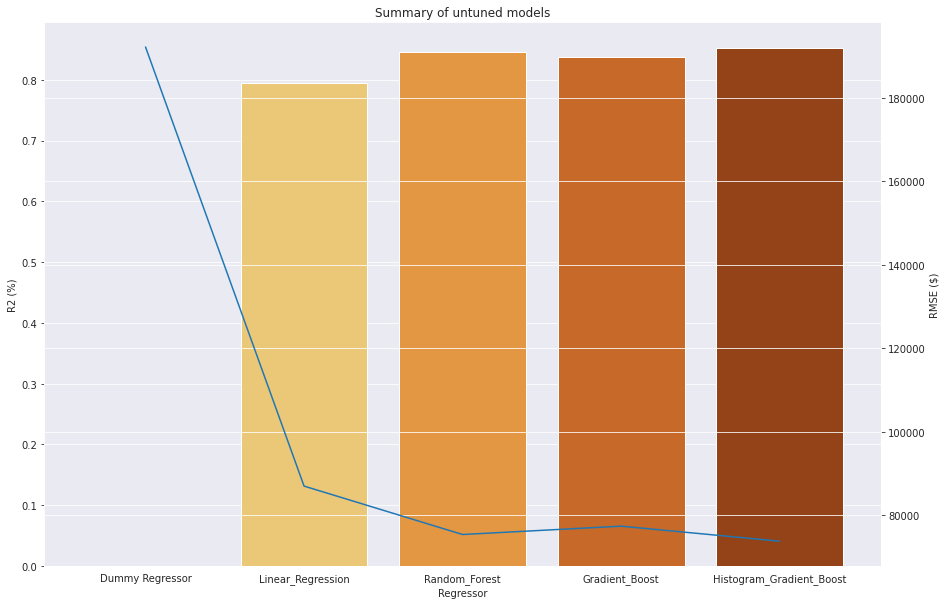

In [13]:
plt.figure(figsize=(15,10))
ax1 = sns.barplot(data = untuned_summary_df, y = 'R2', x = 'Regressor', palette = sns.color_palette('YlOrBr', n_colors = 5))
ax1.set_ylabel('R2 (%)')
ax1.set_title('Summary of untuned models')
ax2 = plt.twinx()
ax2 = sns.lineplot(data = untuned_summary_df, y = 'RMSE', x = 'Regressor', ax = ax2)
ax2.set_ylabel('RMSE ($)');

### **2.3 Hyper Parameter Tuning**
For hyper parameter tuning, we'll only be focusing on all models apart from our Dummy Regressor and Linear Regression as they have no hyperparameters to tune. We'll also be using a **randomised search cv**. And so, we choose the most influential hyper paramters.

In [14]:
from sklearn.model_selection import RandomizedSearchCV

X_train1_preprocessed = preprocessor.fit_transform(X_train1)
tuned_models_summary_lp = []

**Random Forest**

In [15]:
rf_param_grid = {
    'n_estimators': [150, 170, 200],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [0.2, 0.5, 1],
    'max_depth': [7, 10, 15]
}

rf_rs = RandomizedSearchCV(estimator = RandomForestRegressor(),
                          param_distributions = rf_param_grid,
                          scoring = 'r2',
                          n_jobs = 2,
                          cv = 3,
                          random_state = 42
                          )

search = rf_rs.fit(X_train1_preprocessed, y_train)

Best model.

In [16]:
rf_best_estimator = search.best_estimator_
rf_best_estimator

RandomForestRegressor(max_depth=10, max_features=0.2, n_estimators=170)

In [17]:
best_rf_lp = RandomForestRegressor(max_depth = 15, 
                                   max_features = 0.2,
                                   n_estimators = 170)

In [18]:
best_rf_lp_r2 = np.mean(cross_val_score(best_rf_lp, 
                          X_train_processed, 
                          y_train, 
                          scoring = 'r2', 
                          cv = 5))

best_rf_lp_RMSE = (np.mean(cross_val_score(best_rf_lp, 
                                          X_train_processed, 
                                          y_train, 
                                          scoring = 'neg_mean_squared_error',
                                          cv = 5))*(-1))**0.5

tuned_models_summary_lp.append({'Regressor': 'Tuned_Random_Forest',
                                'R2': best_rf_lp_r2,
                                'RMSE': best_rf_lp_RMSE
})

**Gradient Boosting**

In [19]:
lp_gb_param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [10, 25, 50, 100],
}

lp_gb_rs = RandomizedSearchCV(estimator = GradientBoostingRegressor(),
                          param_distributions = lp_gb_param_grid,
                          scoring = 'r2',
                          n_jobs = 2,
                          cv = 3,
                          random_state = 42
                          )

lp_gb_search = lp_gb_rs.fit(X_train1_preprocessed, y_train)

In [20]:
lp_gb_best_estimator = lp_gb_search.best_estimator_
lp_gb_best_estimator

GradientBoostingRegressor(learning_rate=0.2)

In [21]:
best_lp_gb = GradientBoostingRegressor(learning_rate=0.2)

In [22]:
best_gb_lp_r2 = np.mean(cross_val_score(best_lp_gb, 
                                        X_train_processed, 
                                        y_train, 
                                        scoring = 'r2', 
                                        cv = 5))

best_gb_lp_RMSE = (np.mean(cross_val_score(best_lp_gb, 
                                          X_train_processed, 
                                          y_train, 
                                          scoring = 'neg_mean_squared_error',
                                          cv = 5))*(-1))**0.5

tuned_models_summary_lp.append({'Regressor': 'Tuned_Gradient_Boosting',
                                'R2': best_gb_lp_r2,
                                'RMSE': best_gb_lp_RMSE
})

**Histogram Gradient Boost**

In [23]:
lp_hgb_param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'min_samples_leaf': [1, 5, 10],
    'max_depth': [7, 10, 15]
}

lp_hgb_rs = RandomizedSearchCV(estimator = HistGradientBoostingRegressor(),
                                param_distributions = lp_hgb_param_grid,
                                scoring = 'r2',
                                n_jobs = 2,
                                cv = 3,
                                random_state = 42
                                )

lp_hgb_search = lp_hgb_rs.fit(X_train1_preprocessed, y_train)

In [24]:
lp_hgb_best_estimator = lp_hgb_search.best_estimator_
lp_hgb_best_estimator

HistGradientBoostingRegressor(max_depth=15, min_samples_leaf=10)

In [25]:
best_lp_hgb = HistGradientBoostingRegressor(max_depth=15, min_samples_leaf=10)

In [26]:
best_hgb_lp_r2 = np.mean(cross_val_score(best_lp_hgb, 
                                        X_train_processed, 
                                        y_train, 
                                        scoring = 'r2', 
                                        cv = 5))

best_hgb_lp_RMSE = (np.mean(cross_val_score(best_lp_hgb, 
                                            X_train_processed, 
                                            y_train, 
                                            scoring = 'neg_mean_squared_error',
                                            cv = 5))*(-1))**0.5

tuned_models_summary_lp.append({'Regressor': 'Tuned_Histogram_Gradient_Boosting',
                                'R2': best_hgb_lp_r2,
                                'RMSE': best_hgb_lp_RMSE
})

### **2.4 Tuned Models Summary**

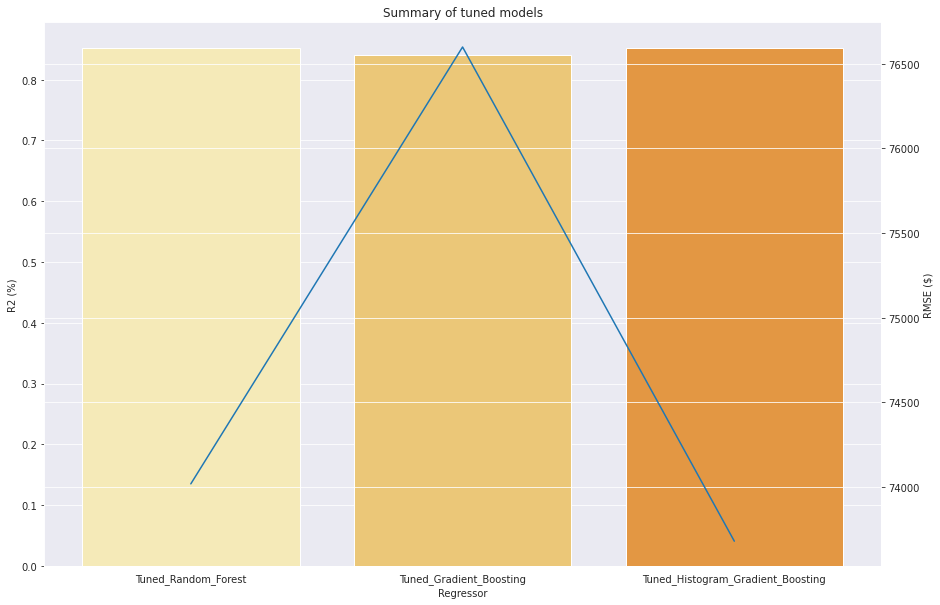

In [27]:
tuned_models_summary_lp_df = pd.DataFrame(tuned_models_summary_lp)

plt.figure(figsize=(15,10))
ax1 = sns.barplot(data = tuned_models_summary_lp_df, y = 'R2', x = 'Regressor', palette = sns.color_palette('YlOrBr', n_colors = 5))
ax1.set_ylabel('R2 (%)')
ax1.set_title('Summary of tuned models')
ax2 = plt.twinx()
ax2 = sns.lineplot(data = tuned_models_summary_lp_df, y = 'RMSE', x = 'Regressor', ax = ax2)
ax2.set_ylabel('RMSE ($)');


## **3.0 High Prices**
We'll begin with the high prices first i.e. houses over $1mil.

### **3.1 Train Test Split**

In [33]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

### **3.2 Modelling**

In [45]:
high_models = {'Dummy Regressor':
                {'regressor': DummyRegressor(),
                'preprocessor': preprocessor,
                'val_cross_val_r2': None,
                'val_cross_val_RMSE': None
                },
              'Linear_Regression':
                {'regressor': LinearRegression(),
                'preprocessor': preprocessor,
                'val_cross_val_r2': None,
                'val_cross_val_RMSE': None
                },
              'Random_Forest':
                {'regressor': best_rf_lp,
                'preprocessor': preprocessor,
                'val_cross_val_r2': None,
                'val_cross_val_RMSE': None
                },
              'Gradient_Boost':
                {'regressor': best_lp_gb,
                'preprocessor': preprocessor,
                'val_cross_val_r2': None,
                'val_cross_val_RMSE': None
                },
              'Histogram_Gradient_Boost':
                {'regressor': best_lp_hgb,
                'preprocessor': preprocessor,
                'val_cross_val_r2': None,
                'val_cross_val_RMSE': None
                }
      }

In [46]:
for name, model in high_models.items():
  # Set our variables
  X_train = X_train2
  y_train = y_train2
  X_test = X_test2
  y_test = y_test2
  # process our X train and X test
  X_train_processed = model['preprocessor'].fit_transform(X_train)
  X_test_processed = model['preprocessor'].transform(X_test)
  # fitting our model
  regressor = model['regressor']
  regressor.fit(X_train_processed, y_train)
  #scoring our train data
  model['val_cross_val_r2'] = np.mean(cross_val_score(regressor, 
                                                X_train_processed, 
                                                y_train, 
                                                scoring = 'r2', 
                                                cv = 5))
  
  model['val_cross_val_RMSE'] = (np.mean(cross_val_score(regressor, 
                                                  X_train_processed, 
                                                  y_train, 
                                                  scoring = 'neg_mean_squared_error',
                                                  cv = 5))*(-1))**0.5
  

In [47]:
high_models_summary_list = []
for name, model in high_models.items():
  high_models_summary_list.append({'Regressor': name, 'R2': round(model['val_cross_val_r2'], 3), 'RMSE': round(model['val_cross_val_RMSE']/100)*100})

high_models_summary_df = pd.DataFrame(high_models_summary_list)
high_models_summary_df.sort_values(by = 'R2', ascending = False)

,Regressor,R2,RMSE
2,Random_Forest,0.337,284800
3,Gradient_Boost,0.287,293300
4,Histogram_Gradient_Boost,0.263,297600
1,Linear_Regression,0.222,307600
0,Dummy Regressor,-0.004,354200


**SUMMARY** <br>
>Best model: ***Random Forest*** <br>
>R2: ***0.337%*** <br>
>RMSE: ***$284800***

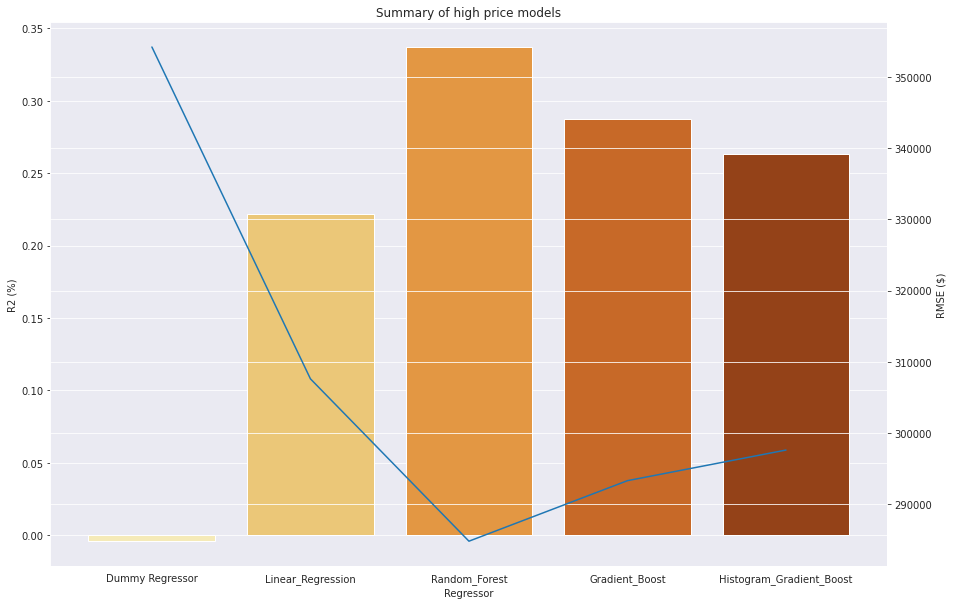

In [48]:
plt.figure(figsize=(15,10))
ax1 = sns.barplot(data = high_models_summary_df, y = 'R2', x = 'Regressor', palette = sns.color_palette('YlOrBr', n_colors = 5))
ax1.set_ylabel('R2 (%)')
ax1.set_title('Summary of high price models')
ax2 = plt.twinx()
ax2 = sns.lineplot(data = high_models_summary_df, y = 'RMSE', x = 'Regressor', ax = ax2)
ax2.set_ylabel('RMSE ($)');

Terrible performance. Most likely due to low correlations between features and the target.

## **4.0 Test Data**

### **4.1 Low prices**
We'll now use our best model on our test data.

In [71]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X_train1_processed = preprocessor.fit_transform(X_train1)
X_test1_processed = preprocessor.transform(X_test1)
best_lp_hgb.fit(X_train1_processed, y_train1)

X_test1_predictions = best_lp_hgb.predict(X_test1_processed)

lp_test_r2 = r2_score(y_test1, X_test1_predictions)
lp_test_RMSE = mean_squared_error(y_test1, X_test1_predictions, squared = False)

In [78]:
print(f'test_r2: {round(lp_test_r2, 3)} - test_RMSE: {round(lp_test_RMSE/100)*100}')

test_r2: 0.852 - test_RMSE: 73500


### **4.2 High prices**

In [79]:
X_train2_processed = preprocessor.fit_transform(X_train2)
X_test2_processed = preprocessor.transform(X_test2)
best_hp_hgb = best_lp_hgb
best_hp_hgb.fit(X_train2_processed, y_train2)

X_test2_predictions = best_hp_hgb.predict(X_test2_processed)

hp_test_r2 = r2_score(y_test2, X_test2_predictions)
hp_test_RMSE = mean_squared_error(y_test2, X_test2_predictions, squared = False)

In [80]:
print(f'test_r2: {round(hp_test_r2, 3)} - test_RMSE: {round(hp_test_RMSE/100)*100}')

test_r2: 0.388 - test_RMSE: 317100


## **5.0 Saving Our Models**

In [82]:
import pickle
# low price model
pickle.dump(best_lp_hgb, open('models/low_price_best_model.pickl', 'wb'))
# high price model
pickle.dump(best_hp_hgb, open('models/high_price_best_model.pickl', 'wb'))
# also we should save our preprocessing
preprocessing_dict = {'preprocessor': preprocessor, 'numeric_transformer': numeric_transformer}
pickle.dump(best_hp_hgb, open('models/preprocessing_dict.pickl', 'wb'))